# Optimization de paramètres ARIMA pour Tronox 2020

In [3]:
# %load ./_Snippets/finance_import_block.py
# Uncomment lorsque qu'une nouvelle ligne s'ajoute

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
#from pandas.plotting import register_matplotlib_converters
#register_matplotlib_converters()
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
from yahoofinancials import YahooFinancials

import warnings
warnings.filterwarnings('ignore')

# Print automatiquement toutes les variables de la cellule (pas juste la dernière)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #"last_expr" pour rétablir par défaut

%config InlineBackend.figure_format ='retina'

# Package maison
from FinForecast import ArimaForecast as af
from FinForecast import InvestStrat


In [45]:
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode

In [6]:
TROX = pd.read_csv('_Input/TROX_0114-0720.csv', parse_dates= True)
TROX.index = pd.to_datetime(TROX.Date)
TROX = TROX.drop(columns= ['Date'])

In [7]:
trox_2019= TROX.loc['06-2018':'12-2019']

In [11]:
trox_2019_rtn5 = trox_2019['Adj Close'].pct_change(5)*100
trox_2019_rtn5.dropna(inplace= True)

Date
2018-06-08    3.958207
2018-06-11    5.797093
2018-06-12    5.447669
2018-06-13    6.866981
2018-06-14    4.667407
                ...   
2019-12-24    4.298240
2019-12-26    3.571431
2019-12-27   -2.382977
2019-12-30   -2.245242
2019-12-31   -2.725718
Name: Adj Close, Length: 394, dtype: float64

In [12]:
# Transform to stationary x - rolling mean deviation
trox_2019_rtn5_stdev, df_ravg_t = af.tfrm_to_MinusMean(trox_2019_rtn5)

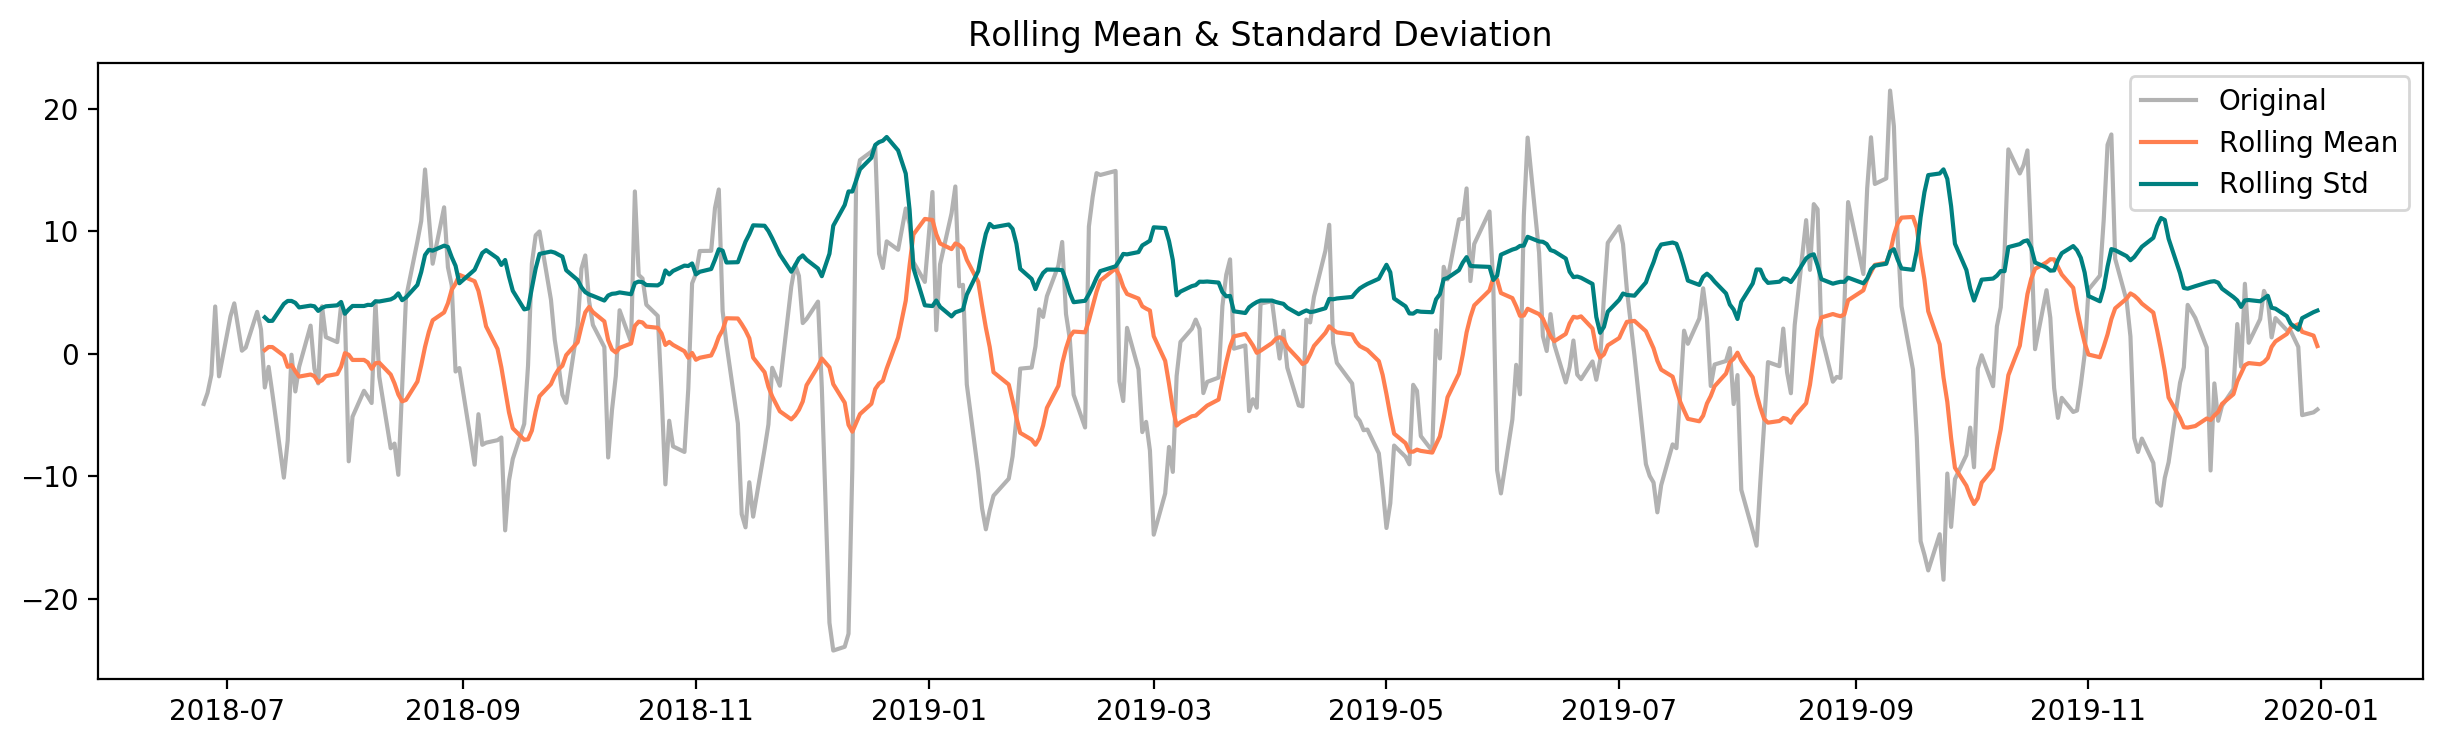

Mean MinMax Delta: 23.434167050601516
Std MinMax Delta: 15.985247722590474
ADF Statistic: -6.901544614122428
p-value: 1.278255660828814e-09
Critical Values:
	1%: -3.4483935212959844
	5%: -2.8694912343676497
	10%: -2.571005879151811


In [13]:
# Assess transformed dataset performances
af.get_stationarity(trox_2019_rtn5_stdev)

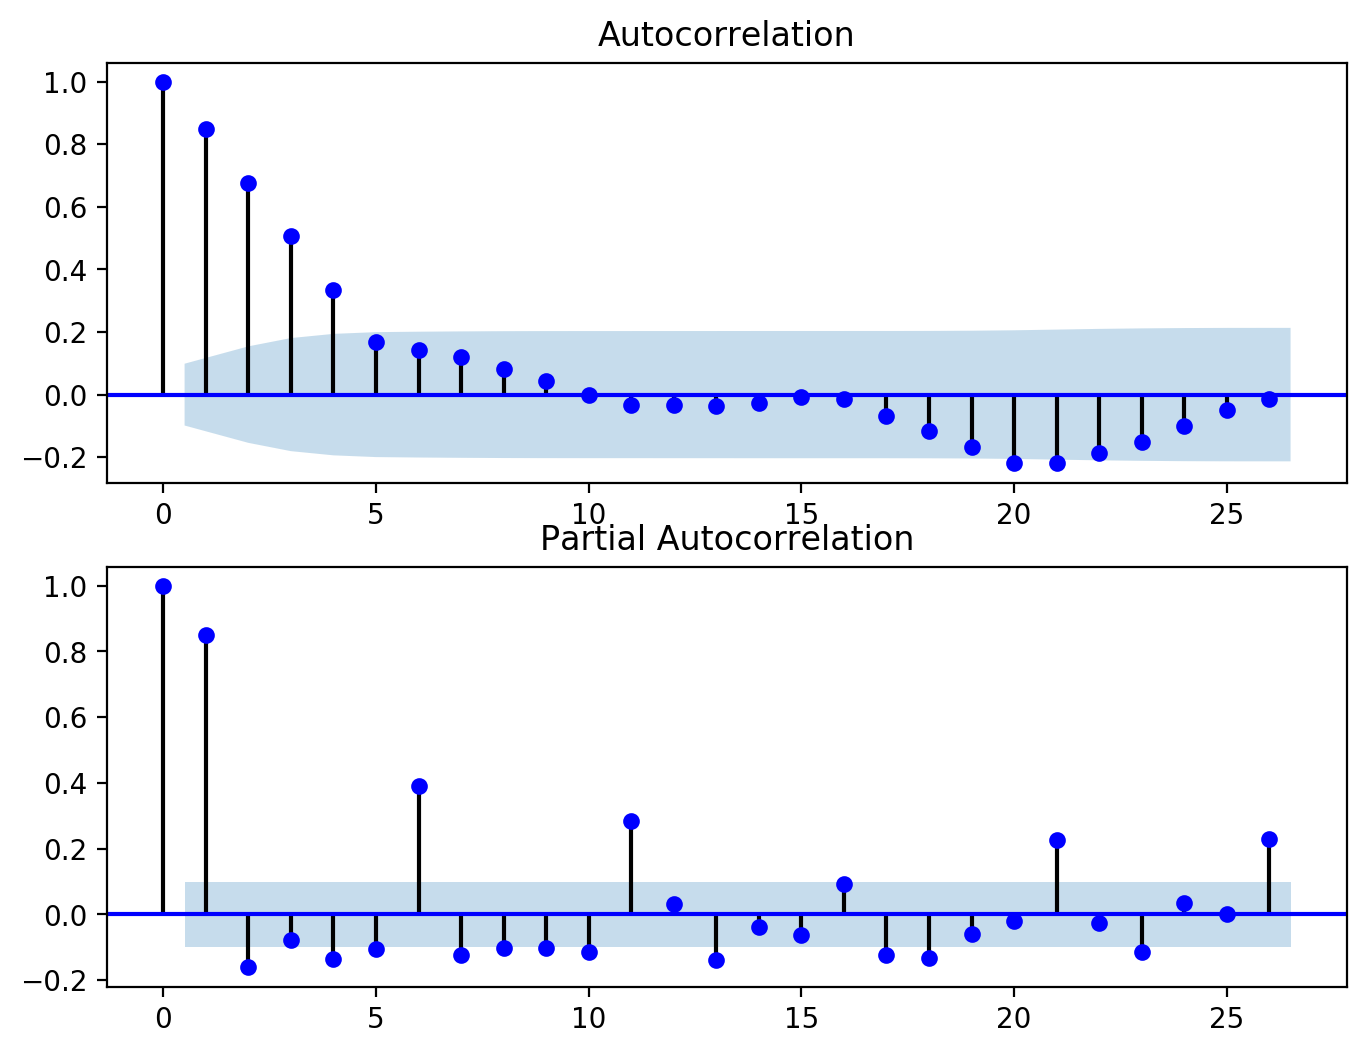

In [14]:
af.plot_corr_function(trox_2019_rtn5)
plt.show()

In [19]:
# Trouver le paramètre optimal sur une série de paramètre
aic_16_5_var = af.aic_optimize(trox_2019_rtn5_stdev, ar_max_range= 16, ma_max_range= 8)

The AIC for an ARIMA(0, 0, 0) is:  2690 
The AIC for an ARIMA(0, 0, 1) is:  2435 
The AIC for an ARIMA(0, 0, 2) is:  2295 
The AIC for an ARIMA(0, 0, 3) is:  2295 
The AIC for an ARIMA(0, 0, 4) is:  2083 
The AIC for an ARIMA(0, 0, 5) is:  2085 
The AIC for an ARIMA(0, 0, 6) is:  2086 
The AIC for an ARIMA(0, 0, 7) is:  2087 
The AIC for an ARIMA(1, 0, 0) is:  2271 
The AIC for an ARIMA(1, 0, 1) is:  2259 
The AIC for an ARIMA(1, 0, 2) is:  2259 
The AIC for an ARIMA(1, 0, 3) is:  2221 
The AIC for an ARIMA(1, 0, 4) is:  2085 
The AIC for an ARIMA(1, 0, 5) is:  2070 
The AIC for an ARIMA(1, 0, 6) is:  2070 
The AIC for an ARIMA(1, 0, 7) is:  2088 
The AIC for an ARIMA(2, 0, 0) is:  2255 
The AIC for an ARIMA(2, 0, 1) is:  2227 
The AIC for an ARIMA(2, 0, 2) is:  2226 
The AIC for an ARIMA(2, 0, 3) is:  2187 
The AIC for an ARIMA(2, 0, 4) is:  2086 
The AIC for an ARIMA(2, 0, 5) is:  2070 
The AIC for an ARIMA(2, 0, 6) is:  2071 
The AIC for an ARIMA(2, 0, 7) is:  2071 
The AIC for an A

### Optimal: (2,0,5)
L'AIC optimal est à 2070.
Comme on le retrouve sur plusieurs ordre différence, on peut trancher pour des paramètres optimaux à (2,0,5) pour donner une polynomiale juste assez flexible pour attraper les détails, mais pas trop.

## Validation de performance
### Paramètres de 2019 sur data 2020 en crise

In [37]:
ticker = 'TROX'
yahoo_financials = YahooFinancials(ticker)

data = yahoo_financials.get_historical_price_data(start_date='2020-01-01', 
                                                  end_date='2020-08-25', 
                                                  time_interval='daily')

# Extraire 'price' keys du dict vers un df
trox_2020 = pd.DataFrame(data[ticker]['prices'])

# Remplacer 'formatted_date' col par 'Date'
col = list(trox_2020.columns) 
col[-1] = 'Date'
trox_2020.columns = col

# Set index to 'Date'
trox_2020 = trox_2020.drop('date', axis=1).set_index('Date')

trox_2020['rtn5'] = trox_2020['adjclose'].pct_change(5)*100
trox_2020['rtn5_stdev'], trox_2020_ravg = af.tfrm_to_MinusMean(trox_2020['rtn5'])
col_drop = list(trox_2020.columns[:4])
trox_2020.drop(columns= col_drop, inplace= True)

trox_2020.dropna(inplace=True)
trox_2020.head()

,volume,adjclose,rtn5,rtn5_stdev
Date,,,,
2020-01-27,1851900,9.284901,-11.737515,-9.213959
2020-01-28,1037100,9.265456,-6.200777,-3.198093
2020-01-29,787400,9.177953,-5.600007,-1.713216
2020-01-30,819400,9.041841,-9.268292,-3.586026
2020-01-31,1887200,8.225159,-14.717733,-6.621883


In [38]:
window_size = 85

# Get temporary df of rolling averages
df_roll_temp= af.rollwin_ARIMA(trox_2020['rtn5_stdev'], 
                               actual= 'rtn5_stdev', 
                               ARIMA_order= (2,0,5), 
                               window_size= window_size)

In [40]:
# Stiching all together
df_roll_temp['rtn5'] = trox_2020['rtn5'].iloc[window_size: :]
df_roll_temp.columns = ['rtn5_stdev', 'Pred_stdev', 'Erreur', 'rtn5']
# Selon système d'équation résolut sur papier
df_roll_temp['Pred_rtn5'] = df_roll_temp['rtn5'] - df_roll_temp['Erreur']
trox_2020_pred = df_roll_temp.copy()


# Créer une valeur bool indiquant une différence entre la direction du retour prédit vs actuel
trox_2020_pred['Erreur_Dir'] = ((trox_2020_pred['rtn5'] < 0) 
                                      & (trox_2020_pred['Pred_rtn5'] > 0)) | ((trox_2020_pred['rtn5'] > 0) 
                                                                                    & (trox_2020_pred['Pred_rtn5'] < 0))

In [42]:
trox_2020_pred['Erreur_Dir'].value_counts(normalize=True)

False    0.854839
True     0.145161
Name: Erreur_Dir, dtype: float64

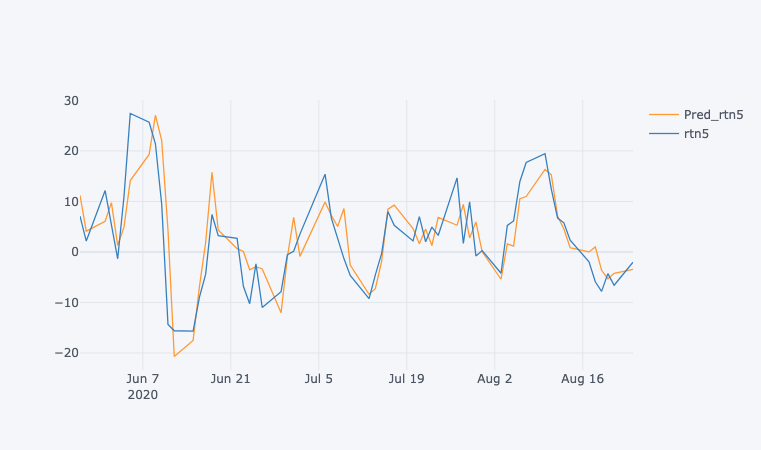

In [46]:
trox_2020_pred[['Pred_rtn5', 'rtn5']].iplot()

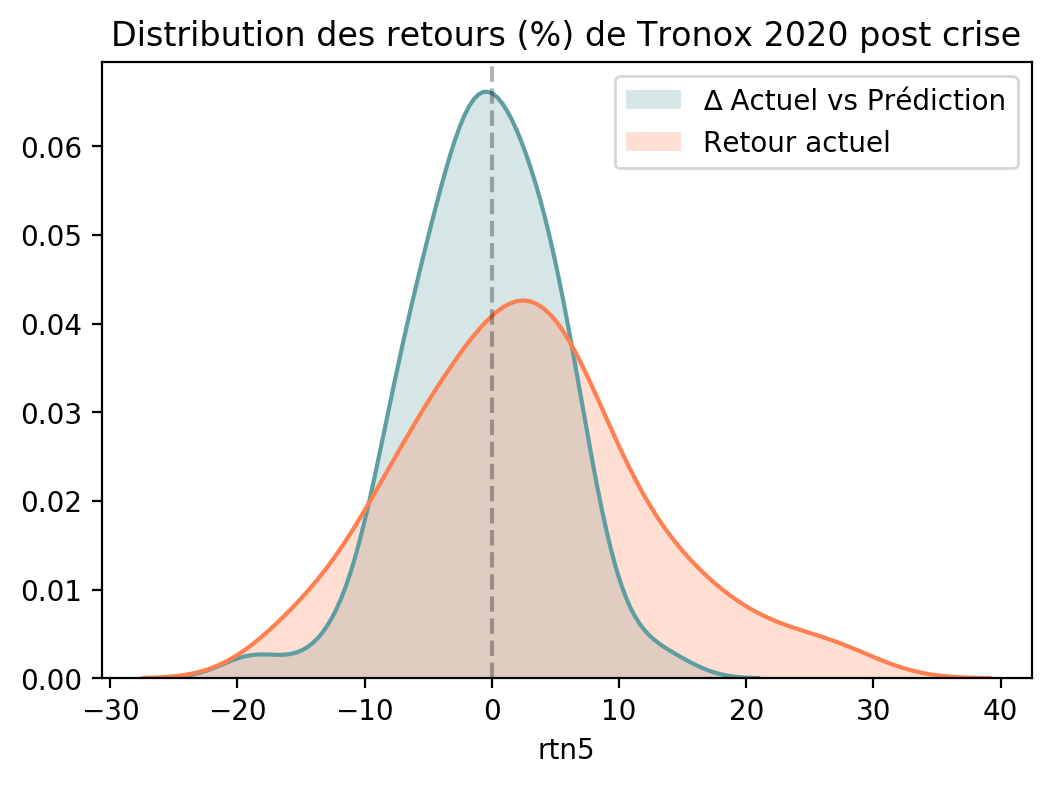

In [51]:
_= fig= plt.figure(figsize= (6, 4))
_= sns.distplot(trox_2020_pred['Erreur'], hist=False, color="cadetblue", kde_kws={"shade": True})
_= sns.distplot(trox_2020_pred['rtn5'], hist=False, color="coral", kde_kws={"shade": True})
_= plt.legend(('∆ Actuel vs Prédiction', 'Retour actuel'))
_= plt.axvline(x= 0, linestyle='--', color='k', alpha= 0.3)
_= plt.title('Distribution des retours (%) de Tronox 2020 post crise')
plt.show()

In [53]:
print("Moyenne de l'erreur: {:.3f}% ".format(trox_2020_pred['Erreur'].mean()))
print("Écart type de l'erreur: {:.3f}%".format(trox_2020_pred['Erreur'].std()))
print('____________________________')
print("Retour moyen actuel: {:.3f}% ".format(trox_2020_pred['rtn5'].mean()))
print("Retour moyen prédit: {:.3f}% ".format(trox_2020_pred['Pred_rtn5'].mean()))
print("Écart type des retours actuels: {:.3f}%".format(trox_2020_pred['rtn5'].std()))
print("Écart type des retours prédits: {:.3f}% ".format(trox_2020_pred['Pred_rtn5'].std()))

Moyenne de l'erreur: -0.698% 
Écart type de l'erreur: 5.588%
____________________________
Retour moyen actuel: 2.579% 
Retour moyen prédit: 3.277% 
Écart type des retours actuels: 9.422%
Écart type des retours prédits: 8.521% 


In [47]:
trox_2020_pred

,rtn5_stdev,Pred_stdev,Erreur,rtn5,Pred_rtn5,Erreur_Dir
Date,,,,,,
2020-05-28,6.444121,10.577832,-4.133711,7.088986,11.222696,False
2020-05-29,1.378438,3.339468,-1.961030,2.153843,4.114872,False
2020-06-01,9.597193,3.510421,6.086772,12.159999,6.073227,False
2020-06-02,2.490123,6.878124,-4.388001,5.381167,9.769168,False
2020-06-03,-5.625142,-3.003953,-2.621189,-1.355013,1.266176,True
...,...,...,...,...,...,...
2020-08-18,-12.372565,-5.478078,-6.894487,-5.898510,0.995976,True
2020-08-19,-13.983027,-9.801676,-4.181351,-7.807642,-3.626291,False
2020-08-20,-9.671158,-10.676123,1.004965,-4.292039,-5.297005,False


### Conclusions
Malgré la crise l'erreur de direction est similaire aux autres titres comparables. Là où la crise semble avoir le plus grand influence, c'est sur la magnétude de la prédiction, légèrement moins précise que les comparables.

## Validation sur "Close"
au lieu de "Adj Close"

In [54]:
trox_2019_rtn5c = trox_2019['Close'].pct_change(5)*100
trox_2019_rtn5c.dropna(inplace= True)

In [55]:
# Transform to stationary x - rolling mean deviation
trox_2019_rtn5c_stdev, df_ravg_t = af.tfrm_to_MinusMean(trox_2019_rtn5c)

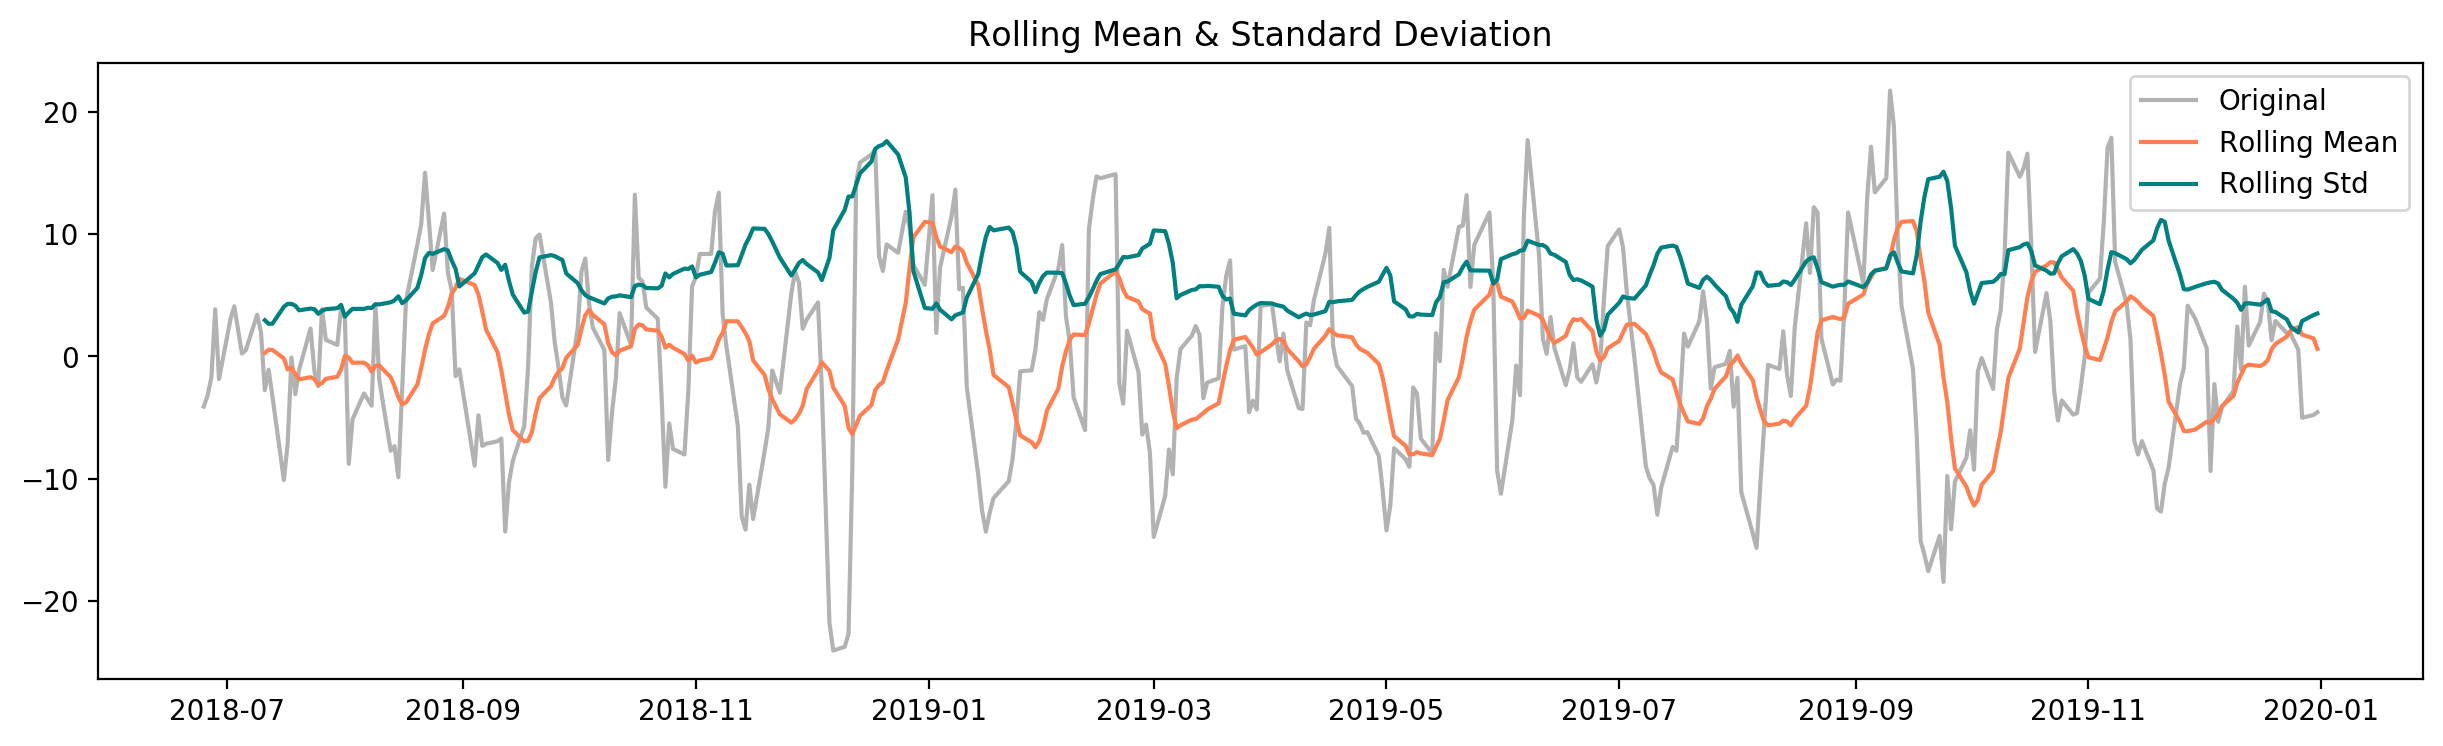

Mean MinMax Delta: 23.290562861545396
Std MinMax Delta: 15.92105425214933
ADF Statistic: -6.8557768007500215
p-value: 1.6499434838558625e-09
Critical Values:
	1%: -3.4483935212959844
	5%: -2.8694912343676497
	10%: -2.571005879151811


In [56]:
# Assess transformed dataset performances
af.get_stationarity(trox_2019_rtn5c_stdev)

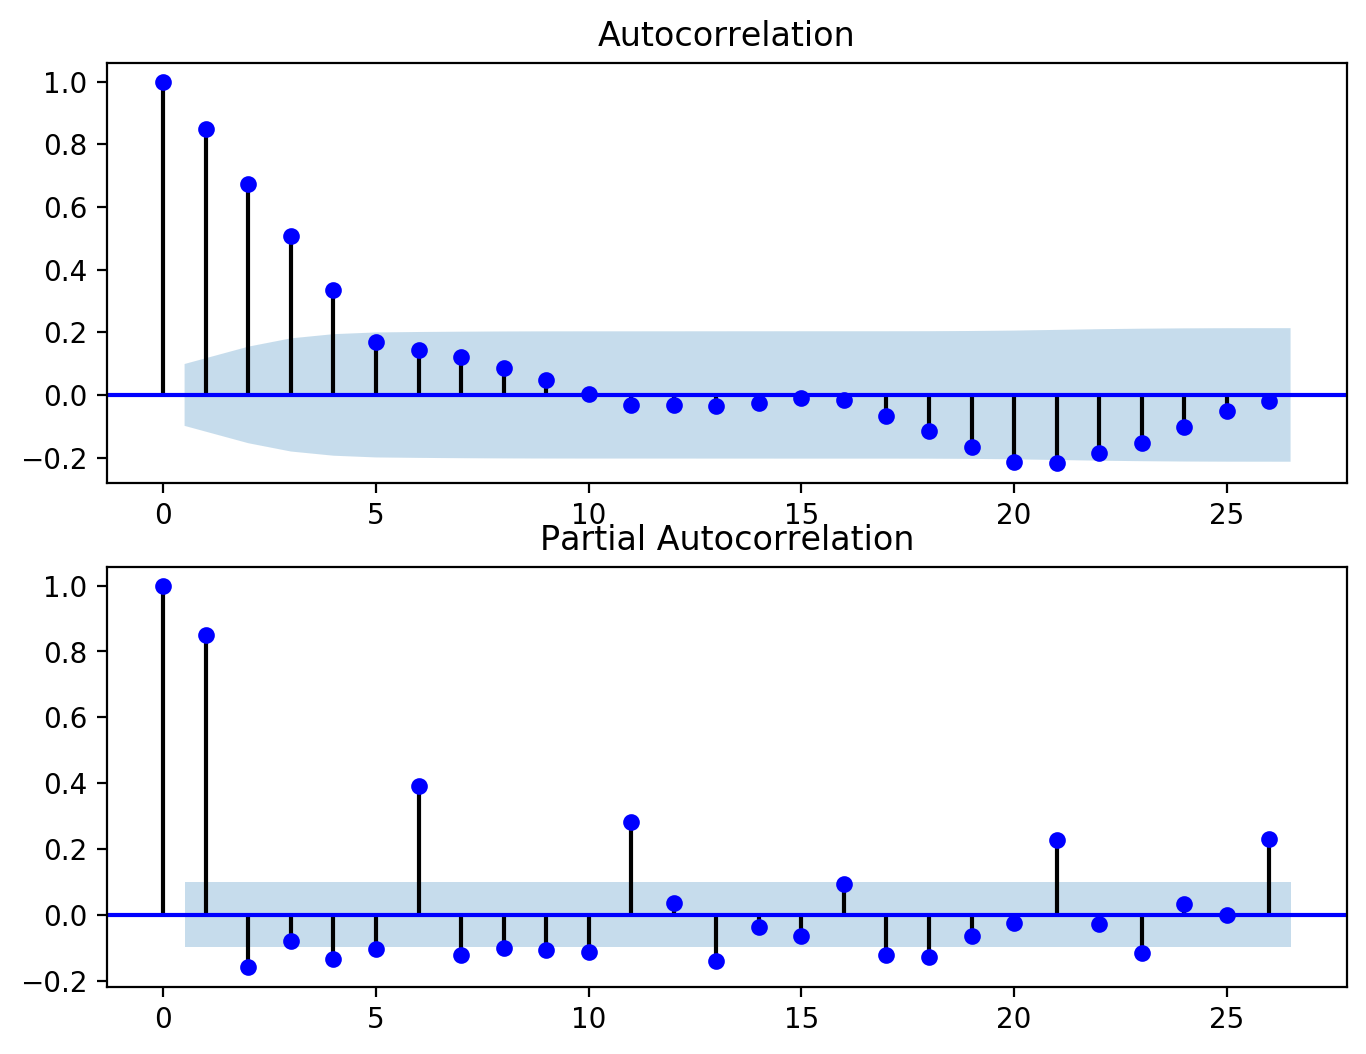

In [57]:
af.plot_corr_function(trox_2019_rtn5c)
plt.show()

In [58]:
# Trouver le paramètre optimal sur une série de paramètre
aic_16_5_var = af.aic_optimize(trox_2019_rtn5c_stdev, ar_max_range= 16, ma_max_range= 8)

The AIC for an ARIMA(0, 0, 0) is:  2689 
The AIC for an ARIMA(0, 0, 1) is:  2434 
The AIC for an ARIMA(0, 0, 2) is:  2295 
The AIC for an ARIMA(0, 0, 3) is:  2295 
The AIC for an ARIMA(0, 0, 4) is:  2083 
The AIC for an ARIMA(0, 0, 5) is:  2085 
The AIC for an ARIMA(0, 0, 6) is:  2086 
The AIC for an ARIMA(0, 0, 7) is:  2087 
The AIC for an ARIMA(1, 0, 0) is:  2270 
The AIC for an ARIMA(1, 0, 1) is:  2259 
The AIC for an ARIMA(1, 0, 2) is:  2258 
The AIC for an ARIMA(1, 0, 3) is:  2222 
The AIC for an ARIMA(1, 0, 4) is:  2085 
The AIC for an ARIMA(1, 0, 5) is:  2070 
The AIC for an ARIMA(1, 0, 6) is:  2070 
The AIC for an ARIMA(1, 0, 7) is:  2086 
The AIC for an ARIMA(2, 0, 0) is:  2255 
The AIC for an ARIMA(2, 0, 1) is:  2228 
The AIC for an ARIMA(2, 0, 2) is:  2226 
The AIC for an ARIMA(2, 0, 3) is:  2187 
The AIC for an ARIMA(2, 0, 4) is:  2086 
The AIC for an ARIMA(2, 0, 5) is:  2070 
The AIC for an ARIMA(2, 0, 6) is:  2072 
The AIC for an ARIMA(2, 0, 7) is:  2072 
The AIC for an A

### Optimal: (2,0,5)
L'AIC optimal est à 2070.
Comme on le retrouve sur plusieurs ordre différence, on peut trancher pour des paramètres optimaux à (2,0,5) pour donner une polynomiale juste assez flexible pour attraper les détails, mais pas trop.

## Validation de performance
### Paramètres de 2019 sur data 2020 en crise

In [59]:
ticker = 'TROX'
yahoo_financials = YahooFinancials(ticker)

data = yahoo_financials.get_historical_price_data(start_date='2020-01-01', 
                                                  end_date='2020-08-25', 
                                                  time_interval='daily')

# Extraire 'price' keys du dict vers un df
trox_2020c = pd.DataFrame(data[ticker]['prices'])

# Remplacer 'formatted_date' col par 'Date'
col = list(trox_2020c.columns) 
col[-1] = 'Date'
trox_2020c.columns = col

# Set index to 'Date'
trox_2020c = trox_2020c.drop('date', axis=1).set_index('Date')

trox_2020c['rtn5'] = trox_2020c['close'].pct_change(5)*100
trox_2020c['rtn5_stdev'], trox_2020c_ravg = af.tfrm_to_MinusMean(trox_2020c['rtn5'])
col_drop = list(trox_2020c.columns[:4])
trox_2020c.drop(columns= col_drop, inplace= True)

trox_2020c.dropna(inplace=True)
trox_2020c.head()

,volume,adjclose,rtn5,rtn5_stdev
Date,,,,
2020-01-27,1851900,9.284901,-11.737519,-9.213962
2020-01-28,1037100,9.265456,-6.200789,-3.198105
2020-01-29,787400,9.177953,-5.600004,-1.713214
2020-01-30,819400,9.041841,-9.268291,-3.586025
2020-01-31,1887200,8.225159,-14.717742,-6.621892


In [60]:
window_size = 85

# Get temporary df of rolling averages
df_roll_temp_c= af.rollwin_ARIMA(trox_2020c['rtn5_stdev'], 
                               actual= 'rtn5_stdev', 
                               ARIMA_order= (2,0,5), 
                               window_size= window_size)

In [61]:
# Stiching all together
df_roll_temp_c['rtn5'] = trox_2020c['rtn5'].iloc[window_size: :]
df_roll_temp_c.columns = ['rtn5_stdev', 'Pred_stdev', 'Erreur', 'rtn5']
# Selon système d'équation résolut sur papier
df_roll_temp_c['Pred_rtn5'] = df_roll_temp_c['rtn5'] - df_roll_temp_c['Erreur']
trox_2020c_pred = df_roll_temp_c.copy()


# Créer une valeur bool indiquant une différence entre la direction du retour prédit vs actuel
trox_2020c_pred['Erreur_Dir'] = ((trox_2020c_pred['rtn5'] < 0) 
                                      & (trox_2020c_pred['Pred_rtn5'] > 0)) | ((trox_2020c_pred['rtn5'] > 0) 
                                                                                    & (trox_2020c_pred['Pred_rtn5'] < 0))

In [62]:
trox_2020c_pred['Erreur_Dir'].value_counts(normalize=True)

False    0.870968
True     0.129032
Name: Erreur_Dir, dtype: float64

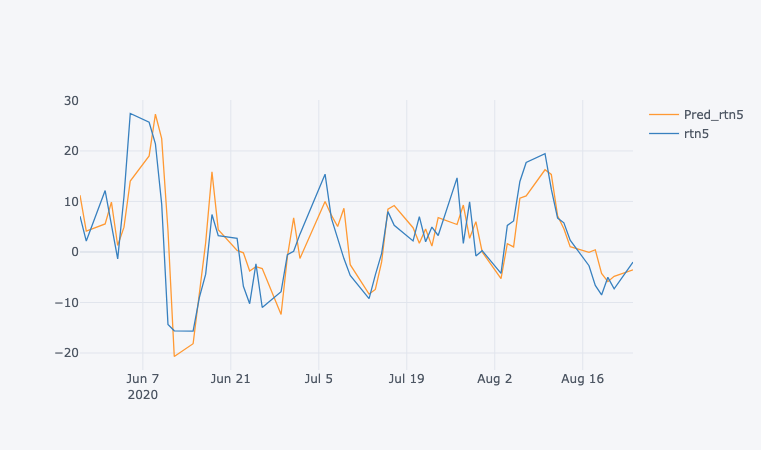

In [63]:
trox_2020c_pred[['Pred_rtn5', 'rtn5']].iplot()

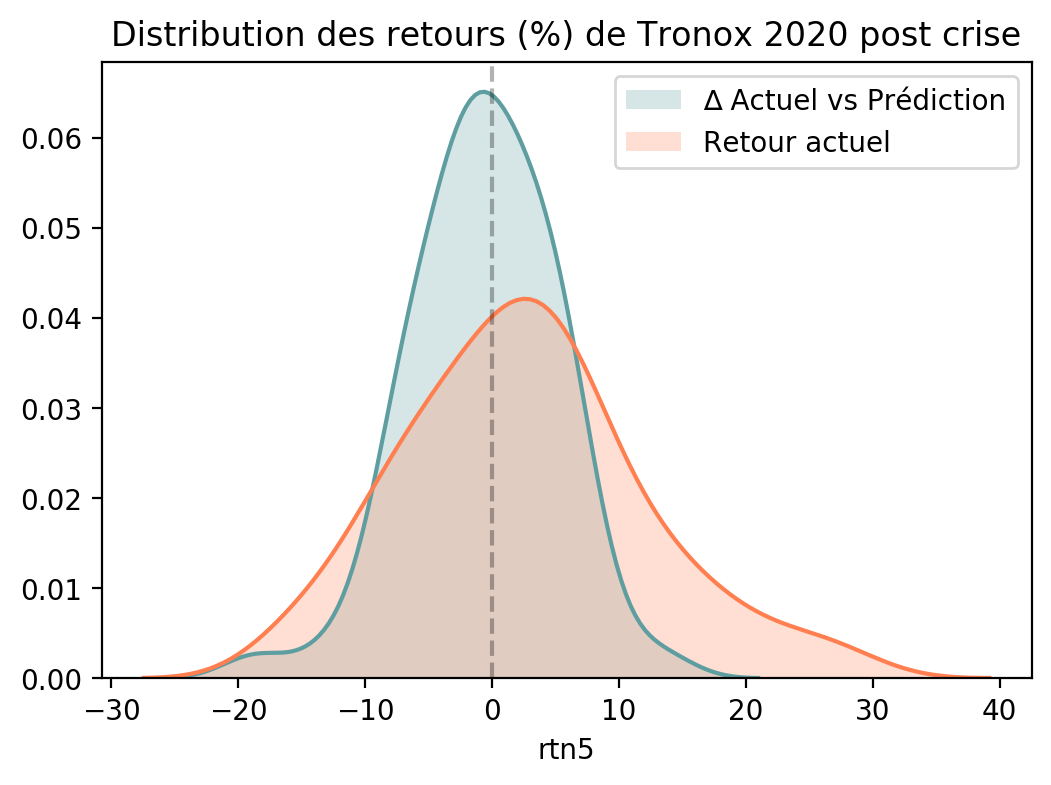

In [64]:
_= fig= plt.figure(figsize= (6, 4))
_= sns.distplot(trox_2020c_pred['Erreur'], hist=False, color="cadetblue", kde_kws={"shade": True})
_= sns.distplot(trox_2020c_pred['rtn5'], hist=False, color="coral", kde_kws={"shade": True})
_= plt.legend(('∆ Actuel vs Prédiction', 'Retour actuel'))
_= plt.axvline(x= 0, linestyle='--', color='k', alpha= 0.3)
_= plt.title('Distribution des retours (%) de Tronox 2020 post crise')
plt.show()

In [65]:
print("Moyenne de l'erreur: {:.3f}% ".format(trox_2020c_pred['Erreur'].mean()))
print("Écart type de l'erreur: {:.3f}%".format(trox_2020c_pred['Erreur'].std()))
print('____________________________')
print("Retour moyen actuel: {:.3f}% ".format(trox_2020c_pred['rtn5'].mean()))
print("Retour moyen prédit: {:.3f}% ".format(trox_2020c_pred['Pred_rtn5'].mean()))
print("Écart type des retours actuels: {:.3f}%".format(trox_2020c_pred['rtn5'].std()))
print("Écart type des retours prédits: {:.3f}% ".format(trox_2020c_pred['Pred_rtn5'].std()))

Moyenne de l'erreur: -0.678% 
Écart type de l'erreur: 5.631%
____________________________
Retour moyen actuel: 2.521% 
Retour moyen prédit: 3.199% 
Écart type des retours actuels: 9.473%
Écart type des retours prédits: 8.627% 


In [47]:
trox_2020c_pred

,rtn5_stdev,Pred_stdev,Erreur,rtn5,Pred_rtn5,Erreur_Dir
Date,,,,,,
2020-05-28,6.444121,10.577832,-4.133711,7.088986,11.222696,False
2020-05-29,1.378438,3.339468,-1.961030,2.153843,4.114872,False
2020-06-01,9.597193,3.510421,6.086772,12.159999,6.073227,False
2020-06-02,2.490123,6.878124,-4.388001,5.381167,9.769168,False
2020-06-03,-5.625142,-3.003953,-2.621189,-1.355013,1.266176,True
...,...,...,...,...,...,...
2020-08-18,-12.372565,-5.478078,-6.894487,-5.898510,0.995976,True
2020-08-19,-13.983027,-9.801676,-4.181351,-7.807642,-3.626291,False
2020-08-20,-9.671158,-10.676123,1.004965,-4.292039,-5.297005,False


### Conclusions
L'erreur de direction sur le "close" est meilleur de 1,5% que sur le "Adj Close". Elle se rapproche d'avantage des autres titres comparables. La magnétude de la prédiction est légèrement améliorée sur le "close", mais la différence n'est pas statistiquement significative.